# Анализ А-В теста: поведение пользователей мобильного приложения 

>**Заказчик:** стартап по продаже продуктов питания
<br>**Платформа:** мобильное приложение
<br>**Задача:** анализ результатов А/В теста и принятие решение на их основе
<br>**Суть:** у дизайнеров возникла идея поменять шрифты в мобильном приложении, в связи с чем был запущен А/А/В тест. На основе результатов теста будем принимать решение о замене шрифтов для всех юзеров
<br>
<br>**Группы:
<br>246:**  А, контрольная группа
<br>**247:** А, контрольная группа
<br>**248:** B, экспериментальная группа

## Предобработка данных

### Старт работы

- подгрузим библиотеки, которые понадобятся в работе
- установим большую длину столбца в библиотеке pandas 
- объявим переменную, считав файл csv, разделим csv на столбцы и посмотрим общее инфо по датасету

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from datetime import datetime
import math as mth
import statistics as stat

In [2]:
pd.options.display.max_colwidth = 400

In [3]:
data = pd.read_csv('logs_exp.csv', delimiter='\t')
display(data.head(2))
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Переименование, формат, дубликаты

- переименуем столбцы, дадим им названия в хорошем тоне
- меняем формат колонки с датой/временем лога на timestamp, выделяем отдельный столбец dt - куда закидываем дату без времени
- смотрим, есть ли у нас строки дубли: считаем их количество + калькулируем долю от общего
- перезаписываем сет, выкидывая строки дубликаты. Смотрим шапку таблицы, чтобы увидеть, что получилось

In [4]:
data.columns = ['event_name', 'device_id', 'event_time', 'exp_id']

In [5]:
data['event_time'] = data['event_time'].astype('datetime64[s]')
data['dt'] = pd.to_datetime(data['event_time'].dt.date)

In [6]:
qt_dup = data.duplicated().sum()
display('кол-во строк дубликатов: ', qt_dup)
display('доля от общего кол-ва строк: ', round(qt_dup/len(data['dt']) * 100,3))

'кол-во строк дубликатов: '

413

'доля от общего кол-ва строк: '

0.169

In [7]:
# небольшое кол-во дубликатов, составляющее менее 1% от датасета. Можем "дропнуть" строки-дубликаты
data = data.drop_duplicates()
data.head(2)

,event_name,device_id,event_time,exp_id,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25


### Проверка наличия юзера в n групп, добавление группы в строку с номером эксперимента

- проверим, есть ли у нас клиенты, которые присутствуют в нескольких группах сразу (посмотрим это путём подсчета уникальных кол-в групп на 1 пользователя)
- заменим названия групп на версии с обозначением, что это за группа - А или В. Для этого поменяем тип данных столбца exp_id на строку и напишем функцию для замены нескольких элементов столбца

In [8]:
suspects = data.groupby('device_id').agg({'exp_id': 'nunique'}).rename(columns={'exp_id': 'qt_of_exps'})
suspects = suspects.query('qt_of_exps > 1')
suspects.index.nunique()

0

#### функция replace_me: добавление группы в номер эксперимента

In [9]:
data['exp_id'] = data['exp_id'].astype('str')
def replace_me(data, replace_values):
    for i, j in replace_values.items():
        data['exp_id'] = data['exp_id'].str.replace(i, j)
    return data

replace_values = {'246': '246_A', '247': '247_A', '248': '248_B'}
data = replace_me(data, replace_values)
data['exp_id'].unique()

array(['246_A', '248_B', '247_A'], dtype=object)

**Итого данные ок: столбцы переименовали, дубли выкинули, проверили, что нет юзеров, попавших в несколько групп сразу (кол-во юзеров с кол-вом групп более 1 равно нулю), для удобства добавили тип группы в столбец exp_id. Можем переходить к верхнеуровнему анализу**

## Общий анализ данных

### Кол-во событий, кол-во юзеров, среднее кол-во событий на юзера

- напишем функцию для просмотра данных по датасету (кол-во событий, кол-во уникальных юзеров, среднее кол-во событий на юзера)
- воспользуемся функцией для просмотра данных
- посмотрим, в какой группе больше событий на пользователей

#### функция common_info: общие данные по датасету

In [10]:
def common_info(data):
    qt_events = data['device_id'].count()
    qt_unique_users = len(data['device_id'].unique())
    avg_qt_events = round(qt_events / qt_unique_users,2)
    avg_qt_events_e = (data.groupby('exp_id', as_index=False)
                       .agg({'event_time':'count', 'device_id': 'nunique'}))
    qt_events_for_user = (data.groupby('device_id', as_index=False)
                          .agg({'event_time': 'count'})
                          .sort_values(by='event_time')
                          .rename(columns={'event_time': 'qt_of_events'}))
    avg_qt_events_e['mean'] = round(avg_qt_events_e['event_time'] / avg_qt_events_e['device_id'],2)

    return qt_events, qt_unique_users, avg_qt_events, qt_events_for_user, avg_qt_events_e

In [11]:
qt_events, qt_unique_users, avg_qt_events, qt_events_for_user, avg_qt_events_e = common_info(data)
display('Кол-во событий в логе:', qt_events)
display('Кол-во уникальных пользователей:', qt_unique_users)
display('Среднее кол-во событий на пользователя:', avg_qt_events)

'Кол-во событий в логе:'

243713

'Кол-во уникальных пользователей:'

7551

'Среднее кол-во событий на пользователя:'

32.28

In [12]:
display(avg_qt_events_e)

,exp_id,event_time,device_id,mean
0,246_A,80181,2489,32.21
1,247_A,77950,2520,30.93
2,248_B,85582,2542,33.67


### Кол-во событий на юнит

> Увидели, что в среднем на пользователя приходится ~32 события. Посмотрим общие данные по распределению кол-ва событий на одного юзера:
<br>
>- построим боксплот по кол-ву событий на юзера
>- посмотрим медиану/моду событий на пользователя
>- посмотрим выборочные перцентили

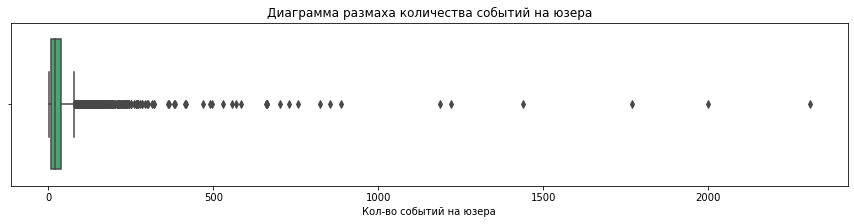

In [13]:
plt.figure(figsize=(15,3))
sns.boxplot(x=qt_events_for_user['qt_of_events'], color='MediumSeaGreen');
plt.title('Диаграмма размаха количества событий на юзера')
plt.xlabel('Кол-во событий на юзера');

> Наибольшая частота наблюдается в диапазоне нескольких десятков событий на юзера. Есть и выбросы - свыше 100 и даже 2000 событий. Также плохо видно сам "ящик" - изменим границы оси Х:

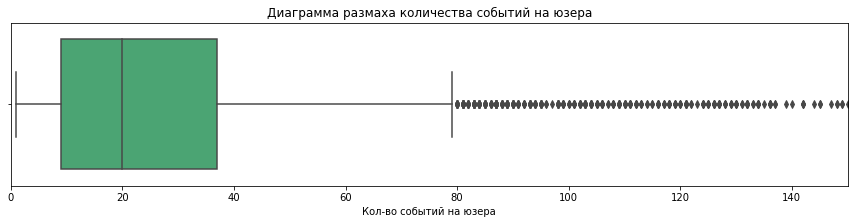

In [14]:
plt.figure(figsize=(15,3))
sns.boxplot(x=qt_events_for_user['qt_of_events'], color='MediumSeaGreen');
plt.title('Диаграмма размаха количества событий на юзера')
plt.xlabel('Кол-во событий на юзера');
plt.xlim([0, 150]);

> Агамс, видим медиану на уровне 20, межквартильный размах в пределах ~ 10-39 событий на юзера. 
><br> Посмотрим 95 и 99 перцентили и медиану с модой:

In [15]:
np.percentile(qt_events_for_user['qt_of_events'], [95,99])

array([ 89. , 200.5])

In [16]:
print('медиана: ', qt_events_for_user['qt_of_events'].median())
print('мода: ', stat.mode(qt_events_for_user['qt_of_events']))

медиана:  20.0
мода:  5


> Видим, что медиана = 20, самое часто встречаемое кол-во событий на пользователя = 5. По перцентилю видим, что 99% юзеров имеют до 200.5 событий. 1% клиентов с кол-м событий больше этой величины можем считать выбросами. Посмотрим детальнее:
>- объявим переменную, в которую списком положим клиентов с кол-м событий более 200.5
>- создадим датасет по этим клиентам, посмотрим, какое у них кол-во событий
>- воспользуемся функцией common_info для просмотра общих данных по датасету
>- посмотрим, какую долю от общего кол-ва уникальных юзеров составляют выбросы + какую долю событий они несут за собой
>- посмотрим в сводной, сколько - и каких - событий совершалось в ту или иную дату

In [17]:
ejects = qt_events_for_user.query('qt_of_events > 200.5')
ejects = list(ejects['device_id'])

In [18]:
look_at_me = data.query('device_id in @ejects')
look_at_me_g = look_at_me.groupby('event_name', as_index=False).agg({'device_id': 'count'})
look_at_me_g.sort_values(by='device_id', ascending=False).reset_index(drop=True)

,event_name,device_id
0,CartScreenAppear,13072
1,PaymentScreenSuccessful,11769
2,OffersScreenAppear,5423
3,MainScreenAppear,4090
4,Tutorial,26


In [19]:
look_at_me_cons = common_info(look_at_me)
qt_events_l, qt_unique_users_l, avg_qt_events_l, qt_events_for_user_l, avg_qt_events_e_l = common_info(look_at_me)
display('Кол-во событий в логе:', qt_events_l)
display('Кол-во уникальных пользователей:', qt_unique_users_l)
display('Среднее кол-во событий на пользователя:', avg_qt_events_l)

'Кол-во событий в логе:'

34380

'Кол-во уникальных пользователей:'

76

'Среднее кол-во событий на пользователя:'

452.37

In [20]:
print('доля от кол-ва уникальных юзеров: ', round(qt_unique_users_l / qt_unique_users * 100, 3))
print('доля от кол-ва событий: ', round(qt_events_l / qt_events * 100, 3))

доля от кол-ва уникальных юзеров:  1.006
доля от кол-ва событий:  14.107


In [21]:
look_at_me_p = look_at_me.pivot_table(index='dt', columns='event_name', values='device_id', aggfunc='count')
look_at_me_p

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
dt,,,,,
2019-07-26,NaN,NaN,NaN,NaN,2.0
2019-07-30,NaN,NaN,1.0,NaN,NaN
2019-07-31,19.0,26.0,45.0,15.0,NaN
2019-08-01,1973.0,534.0,983.0,1754.0,3.0
2019-08-02,2189.0,608.0,761.0,2030.0,8.0
2019-08-03,1959.0,587.0,700.0,1782.0,2.0
2019-08-04,1892.0,566.0,808.0,1704.0,3.0
2019-08-05,2175.0,701.0,849.0,1899.0,5.0
2019-08-06,1586.0,522.0,695.0,1409.0,3.0


**Итого, что видим:**
- по юзерам, у которых более 200 событий, необычная воронка, сосредоточенная на уровнях "корзина" и "оплата"
- доля таких юзеров - 1% от общего кол-ва уникальных юзеров, вместе с тем они генерят нам 14% событий от датасета
- по трактовке воронки варианта 2: либо это клиенты, напрямую попадающие на оплату / в корзину напрямую - минуя главный экран, либо данные собираются странно. Энивэй, необходимо уточнить пути, с помощью которых клиента может перебрасывать на этапы корзины/оплаты.

**На данном этапе никого из клиентов не отсекаем - будем строить воронки по уникальным юзерам (не по кол-ву событий). Необходимо уточнить у бизнеса, кем являются клиенты с высоким кол-вом событий (возможно, это ЮЛ?).**

### Распределение данных по датам

- посмотрим минимум и максимум даты в периоде 
- те же данные посмотрим в разрезе групп

In [22]:
print('Минимальная дата периода:', data['dt'].min())
print('Максимальная дата периода:', data['dt'].max())

Минимальная дата периода: 2019-07-25 00:00:00
Максимальная дата периода: 2019-08-07 00:00:00


In [23]:
dates_e = data.groupby('exp_id', as_index=False).agg({'dt': ['min','max']})
display(dates_e)

exp_id         dt           
                min        max
0  246_A 2019-07-25 2019-08-07
1  247_A 2019-07-25 2019-08-07
2  248_B 2019-07-25 2019-08-07

**Увидели, что минимальные и максимальные даты в разрезе групп не отличаются от общих макс/мин. Это хорошо, тк здесь не возникло вопросов по событийному периоду в разных группах.**

- создадим функцию, которая позволит нам быстро группировать датасет по уровням (опционально: дата, группа или тип события) + делать расчет показателя (кол-во или кол-во уникальных) + делать сортировку по заданным переметрам
- объявим переменную, сделав расчет функцией
- посмотрим данные в графике

#### функция group_me: группировка датасета

In [24]:
def group_me(data, levels=[], function='', sort=[''], ascending=True):
    union = (data.groupby(levels, as_index=False)
             .agg({'device_id': function})
             .rename(columns={'device_id': function})
             .sort_values(by=sort, ascending=ascending)
             .reset_index(drop=True))
    return union

In [25]:
union = group_me(data, levels=['dt'], function='count', sort='dt') # функция считает кол-во событий в разрезе даты

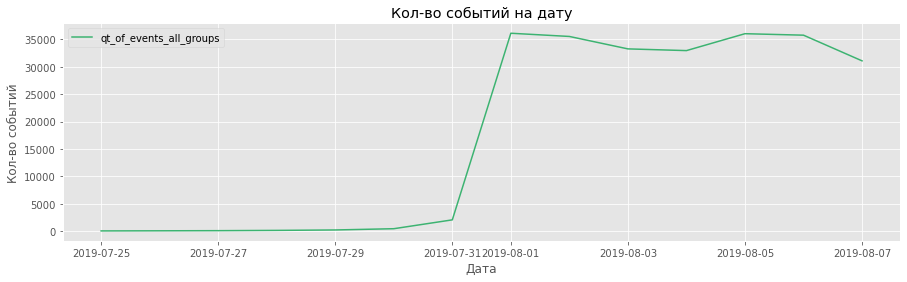

In [26]:
plt.figure(figsize=(15,4))
plt.style.use('ggplot')
plt.plot(union['dt'], union['count'], label='qt_of_events_all_groups', color='MediumSeaGreen');
plt.legend();
plt.title('Кол-во событий на дату');
plt.xlabel('Дата');
plt.ylabel('Кол-во событий');

> Как распределены кол-ва событий по группам? Переиспользуем функцию группировки, добавив разрез по группам и посмотрим графики

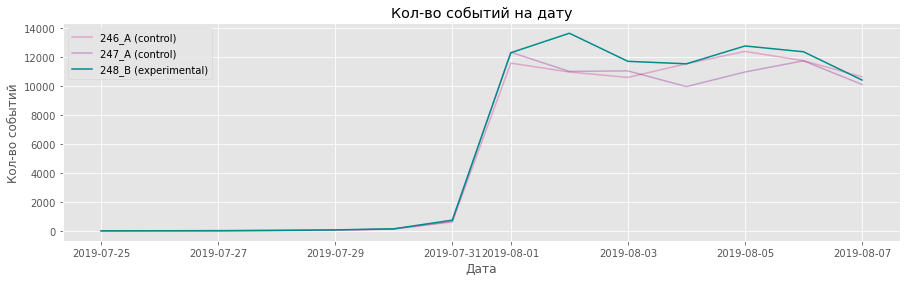

In [27]:
union_e = group_me(data, levels=['dt', 'exp_id'], function='count', sort='dt') #дополнительно сгруппировали по группе
union_246 = union_e.query('exp_id == "246_A"') #сделали отдельные фреймы по каждой группе
union_247 = union_e.query('exp_id == "247_A"')
union_248 = union_e.query('exp_id == "248_B"')

alpha_color = .3 #прозрачность линий групп А

plt.figure(figsize=(15,4))
plt.plot(union_246['dt'], union_246['count'], label='246_A (control)', color='MediumVioletRed', alpha=alpha_color);
plt.plot(union_247['dt'], union_247['count'], label='247_A (control)', color='DarkMagenta', alpha=alpha_color);
plt.plot(union_248['dt'], union_248['count'], label='248_B (experimental)', color='DarkCyan', alpha=1);
plt.legend();
plt.title('Кол-во событий на дату');
plt.xlabel('Дата');
plt.ylabel('Кол-во событий');

**Итого по графикам видим - логи "доехали" к 1 августа 2019 - с этой даты начинается релеватный к анализу объем данных. По графикам отдельных групп аномалий нет - по всем трём число событий примерно на одном уровне и по всем трём объем данных визуально становится достаточным с 1 августа 2019**

### Фильтрация датасета по датам

В предыдущем пункте выявили, что до 1 августа 2019 данных мало. Проверим, насколько корректно будет отбросить данные до этой даты:
- переименуем исходный датасет и перезапишем переменную data отфильтрованным датасетом (с данными с 1 августа 2019 включительно)
- сравним по группам - сколько потеряли уникальных юзеров / сколько событий в кол-ве. Рассчитаем столбцы с разницей; по событиям дополнительно рассчитаем долю потерянных данных от исходного объема в разрезе группы
- посмотрим типы событий, которые потерялись после фильтрации

In [28]:
data_old = data
data = data_old.query('dt >= "2019-08-01"')

In [29]:
compare_users_new = group_me(data, levels=['exp_id'], function='nunique', sort='exp_id')
compare_users_old = group_me(data_old, levels=['exp_id'], function='nunique', sort='exp_id')
compare_events_new = group_me(data, levels=['exp_id'], function='count', sort='exp_id')
compare_events_old = group_me(data_old, levels=['exp_id'], function='count', sort='exp_id')

compare_group = (compare_users_old
                .merge(compare_users_new, left_on='exp_id', right_on='exp_id', how='left')
                .merge(compare_events_old, left_on='exp_id', right_on='exp_id', how='left')
                .merge(compare_events_new, left_on='exp_id', right_on='exp_id', how='left'))
compare_group['diff_users'] = compare_group['nunique_x'] - compare_group['nunique_y']
compare_group['diff_events'] = compare_group['count_x'] - compare_group['count_y']

#добавлен расчет доли удаленных юзеров
compare_group['share_users'] = round(compare_group['diff_users'] / compare_group['nunique_x'] * 100,2)
compare_group['share_events'] = round(compare_group['diff_events'] / compare_group['count_x'] * 100,2)
                 
compare_group.columns = ['exp_id', 'users_before', 'users_after', 'events_before', 'events_after', 'diff_users', 
                        'diff_events', 'share_of_deleted_users', 'share_of_deleted_events']
compare_group


,exp_id,users_before,users_after,events_before,events_after,diff_users,diff_events,share_of_deleted_users,share_of_deleted_events
0,246_A,2489,2484,80181,79302,5,879,0.20,1.10
1,247_A,2520,2513,77950,77022,7,928,0.28,1.19
2,248_B,2542,2537,85582,84563,5,1019,0.20,1.19


In [30]:
compare_types_new = group_me(data, levels=['event_name'], function='count', sort='event_name')
compare_types_old = group_me(data_old, levels=['event_name'], function='count', sort='event_name')

compare_types = compare_types_old.merge(compare_types_new, left_on='event_name', right_on='event_name', how='left')
compare_types['diff'] = compare_types['count_x'] - compare_types['count_y']
compare_types['share'] = round(compare_types['diff'] / compare_types['count_x'] * 100, 2)

compare_types.columns = ['exp_id', 'count_before', 'count_after', 'diff', 'share']
compare_types.sort_values(by='diff', ascending=False)

,exp_id,count_before,count_after,diff,share
1,MainScreenAppear,119101,117328,1773,1.49
2,OffersScreenAppear,46808,46333,475,1.01
0,CartScreenAppear,42668,42303,365,0.86
3,PaymentScreenSuccessful,34118,33918,200,0.59
4,Tutorial,1018,1005,13,1.28


> Переиспользуем функцию common_info для сравнения общих показателей по новому датасету.

In [31]:
qt_events_f, qt_unique_users_f, avg_qt_events_f, qt_events_for_user_f, avg_qt_events_e_f,  = common_info(data)

display('Кол-во событий в логе:', qt_events_f)
display('Кол-во уникальных пользователей:', qt_unique_users_f)
display('Среднее кол-во событий на пользователя:', avg_qt_events_f)

'Кол-во событий в логе:'

240887

'Кол-во уникальных пользователей:'

7534

'Среднее кол-во событий на пользователя:'

31.97

**Будем ли фильтровать данные? Отметим, что мы увидели:**
- потери уникальных юзеров не критичны (5-7 человек на группу)
- по событиям потери есть - но они распределены равномерно по группам и составляют не более 1.5% от исходного объема событий в группе
- все 3 группы остались в достаточном количестве
- после фильтрации события "отвалились" по воронке равномерно (было бы плохо, если б, к примеру, "отвалились" только события оплаты)
- потери кол-ва событий составляют не более 1.5% от исходного объема событий в разрезе вида события
- по общим показателям (тотал событий, тотал уникальных юзеров, средний чек) нет больших отличий в сравнении с исходным датасетом

<br>**Итого можем оставлять фильтрацию и далее работать с данными после 1 августа 2019 включительно.**

## Воронки

### Доля от общего количества юзеров

**Продолжим работать с разрезом по типу события (переименуем для удобства):**
- добавим в этот же сет колонку с кол-м уникальных юзеров в разрезе события + столбец с расчётом доли от общего кол-ва уникальных юзеров
- построим столбчатую диаграмму

In [32]:
types = compare_types_new
all_users = data['device_id'].nunique()

types_users = group_me(data, levels=['event_name'], function='nunique', sort='nunique')
types = types.merge(types_users, left_on='event_name', right_on='event_name', how='left')

types['share_from_all'] = round(types['nunique'] / all_users * 100,2)
types = types.sort_values(by='count', ascending=False).reset_index(drop=True)
display(types)

,event_name,count,nunique,share_from_all
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


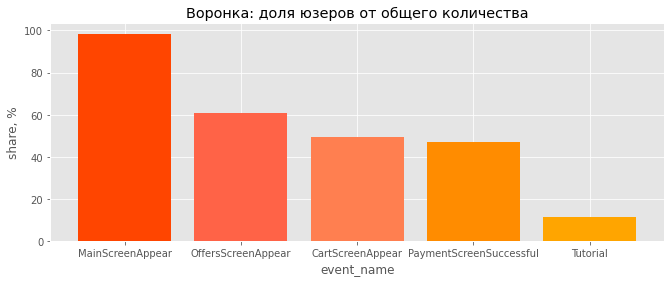

In [33]:
plt.figure(figsize=(11,4))
plt.bar(types['event_name'], types['share_from_all'], 
        color=['#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FFA500']);
plt.title('Воронка: доля юзеров от общего количества');
plt.xlabel('event_name');
plt.ylabel('share, %');

**Явно видим воронку (она логична по последовательности действий + все соотносится по кол-ву событий/юзеров):
<br> 1 MainScreenAppear** | появление главного экрана
<br> **2 OffersScreenAppear** | появление экрана с предложениями (офферами)
<br> **3 CartScreenAppear** | появление экрана с корзиной 
<br> **4 PaymentScreenSuccessful** | появление экрана об успешной оплате покупки
<br> 
<br> А вот шаг **Tutorial** возникает, вероятнее всего, на главном экране. Большинсто юзеров скипает этот шаг - что видно по маленькому числу юзеров. С учетом того, что шаг не входит в воронку оплаты - мы можем отбросить его на следующих этапах.
<br>
<br> Логично распределены и доли участия юзеров в уровнях воронки - *главный экран открыли ~98.5% юзеров* (1.5% могли потеряться после фильтрации - верх воронки произошел до 1 августа, и в фильтрованные данные эти юзеры попали сразу со 2< этапа), *в корзину* после экрана предложений *попадает ~ 50%* от исходного объема, а *до экрана успешной оплаты доходит ~47%* уникальных юзеров.

### Доля от количества юзеров на предыдущем уровне

Посмотрим конверсию между уровнями (какая доля юзеров перешла с главного экрана на экран офферов и так далее).

In [34]:
types['share_from_previous'] = round(types['nunique'] / types['nunique'].shift() * 100,2).fillna(100)
types = types.query('event_name != "Tutorial"') # убрали уровень туториал
types

,event_name,count,nunique,share_from_all,share_from_previous
0,MainScreenAppear,117328,7419,98.47,100.00
1,OffersScreenAppear,46333,4593,60.96,61.91
2,CartScreenAppear,42303,3734,49.56,81.30
3,PaymentScreenSuccessful,33918,3539,46.97,94.78


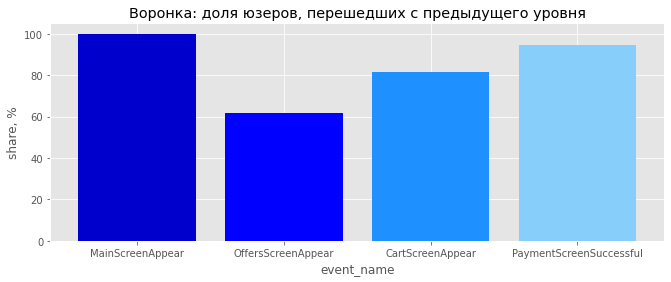

In [35]:
plt.figure(figsize=(11,4))
plt.bar(types['event_name'], types['share_from_previous'], 
        color=['#0000CD', '#0000FF', '#1E90FF', '#87CEFA']);
plt.title('Воронка: доля юзеров, перешедших с предыдущего уровня');
plt.xlabel('event_name');
plt.ylabel('share, %');

По данным видим, что *на экран офферов переходят относительно вяло (около 62%)*, зато есть бодрая конверсия у перешедших: после раздела предложений *81% попадает на экран с корзиной*. Также есть отличная конверсия с корзины - после этого экрана *95% юзеров оплачивают покупку*.

**Итого по воронкам видим, что ~ 46% от общей базы доходит до оплаты. Больше всего пользователей теряется на шаге с офферами - порядка 60% из перешедших на главную заходит в раздел с предложениями.**

## Анализ результатов теста

>- сравнивать группы будем по показателю конверсии на все уровни воронки
>- конверсию смотрим от общего кол-ва уникальных юзеров в группе
>- для проверки наличия различий будем использовать тест об оценке равенства долей (z-тест)

### Сравнение выборок групп типа "А" (246_A, 247_A)

Проверим выборки типа "А" на корректность. В случае, если все ок, тест не покажет статистически значимых различий между группами.
- создадим срезы по группам
- доработаем и переиспользуем функцию группировки для создания отдельного фрейма с группой А
- создадим функцию для формирования списков по каждому уровню воронки и для расчета p_value для z-test
- обозначим нулевую и альтернативную гипотезы
- сравним группы 246_А и 247_А

In [36]:
types_exps = group_me(data, levels=['exp_id', 'event_name'], function='nunique', sort='nunique')
types_exps_g = group_me(data, levels='exp_id', function='nunique', sort='nunique')
types_exps = types_exps.query('event_name != "Tutorial"') # убрали левел туториала

group_246 = (types_exps
              .query('exp_id == "246_A"')
              .sort_values(by=['exp_id', 'nunique'], ascending=False)
              .reset_index(drop=True))
group_247 = (types_exps
              .query('exp_id == "247_A"')
              .sort_values(by=['exp_id', 'nunique'], ascending=False)
              .reset_index(drop=True))
group_248 = (types_exps
              .query('exp_id == "248_B"')
              .sort_values(by=['exp_id', 'nunique'], ascending=False)
              .reset_index(drop=True))

### Добавляем в срезы уровень с тотал кол-вом уникальных юзеров

- вытаскиваем датасет с кол-м уникальных юзеров в каждой группе
- добавляем доп.строки в датасеты каждой группы (аналогичную операцию проделаем ниже с обобщенной группой А)
- перезаписываем датасеты, чтобы кол-во юзеров встало на первое место и к нему можно было бы обращаться по индексу [0] в нашей функции

In [37]:
types_exps_g

,exp_id,nunique
0,246_A,2484
1,247_A,2513
2,248_B,2537


In [38]:
group_246.loc[len(group_246.index)] = ['246_A', 'all_unique_users', int(2484)]
group_247.loc[len(group_247.index)] = ['247_A', 'all_unique_users', int(2513)]
group_248.loc[len(group_247.index)] = ['248_B', 'all_unique_users', int(2537)]

In [39]:
group_246 = group_246.sort_values(by='nunique', ascending=False).reset_index(drop=True)
group_247 = group_247.sort_values(by='nunique', ascending=False).reset_index(drop=True)
group_248 = group_248.sort_values(by='nunique', ascending=False).reset_index(drop=True)

In [40]:
# добавим в функцию фильтр, убрав уровень Tutorial и посчитав кол-во уникальных юзеров в группах А (все группы кроме В)
def group_a(data, levels=[], function='', sort=[''], ascending=True): #на вход: датасет, уровни группировки и функция, которую хотим применить
    data = data.query('event_name != "Tutorial" & exp_id != "248_B"')
    union = (data.groupby(levels, as_index=False)
             .agg({'device_id': function})
             .rename(columns={'device_id': function})
             .sort_values(by=sort, ascending=ascending)
             .reset_index(drop=True))
    unique_users = data['device_id'].nunique()
    return union, unique_users

group_a, unique_a = group_a(data, levels='event_name', function='nunique', sort='nunique')
group_a = (group_a
           .sort_values(by=['nunique'], ascending=False)
           .reset_index(drop=True))

In [41]:
group_a.loc[len(group_a.index)] = ['all_unique_users', int(4995)]
group_a = group_a.sort_values(by='nunique', ascending=False).reset_index(drop=True)

#### функция z_test: z-тест по 2 выборкам и заданному уровню воронки

In [42]:
def z_test(group_1, group_2, level, alpha=0.05): # group_n - выборки, level - уровень воронки, alpha - уровень стат знач-ти
    
    def get_array(group_1, group_2, level=level): #функция для формирования списков по заданному уровню (офферы, корзина, оплата)              
        base = np.array([group_1.loc[0, 'nunique'], group_2.loc[0, 'nunique']]) # кол-во юзеров в группах 
        converse = np.array([group_1.loc[level, 'nunique'], group_2.loc[level, 'nunique']]) # рассматриваемый уровень воронки
        return base, converse 
   
    base, converse = get_array(group_1, group_2, level)
    
    p_1 = converse[0] / base[0]
    p_2 = converse[1] / base[1]
    

    p_combo = (converse[0] + converse[1]) / (base[0] + base[1])
    diff = p_1 - p_2

    z_value = diff / mth.sqrt(p_combo * (1 - p_combo) * (1/base[0] + 1/base[1]))
    distr = st.norm(0,1)

    p_value = round((1 - distr.cdf(abs(z_value))) * 2,5)
    
    if p_value < alpha:
        text_me = 'Отвергаем нулевую гипотезу: между долями есть значимая разница'
    else:
        text_me = 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'   
    
    return p_value, text_me

Сформулируем гипотезы:
    <br>H0 (нулевая гипотеза) - между долями нет статистически значимых различий по показателю конверсии с главного экрана на экран предложений
    <br>H1 (альтеративная гипотеза) - между долями есть статистически значимые различия по показателю конверсии с главного экрана на экран предложений

In [43]:
p_value, text_me = z_test(group_246, group_247, 1)
display(p_value, text_me)

0.75706

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

> **Между выборками групп "А" нет статически значимых различий по показателю конверсии с главного экрана на экран предложений.** Что там с другими уровнями воронки? Пройдемся циклом по оставшимся 2 уровням - переходам в корзину и переходам в экран покупки

In [44]:
for i in range(2, len(group_246['event_name'].unique())):
    p_value, text_me = z_test(group_246, group_247, i)
    display(p_value, text_me)

0.2481

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.22883

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.11457

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

**Итого - p_value по всем конверсиям больше уровня стат.значимости - значит не можем отвергнуть нулевую гипотезу о равенстве групп А. Считаем, что выборки были определены верно - можем переходить к сверке групп "А" с группой "В".**

### Сравнение группы "В" с группой "А" (248_В, 246_А)

Пройдемся циклом по всем уровням воронки, сравнив конверсии группы "В" с группой "А" (246_А, первая контрольная группа) по всем уровням.

Сформулируем гипотезы:
    <br>H0 (нулевая гипотеза) - между долями нет статистически значимых различий по показателю конверсии
    <br>H1 (альтеративная гипотеза) - между долями есть статистически значимые различия по показателю конверсии

In [45]:
display('248_B / 246_A')
for i in range(1, len(group_246['event_name'].unique())):
    p_value, text_me = z_test(group_246, group_248, i)
    display(p_value, text_me)

'248_B / 246_A'

0.29497

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.20836

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.07843

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.21226

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

**Здесь также нет статистически значимых отличий между выборками - везде p_value больше 0.05.**

### Сравнение группы "В" с группой "А" (248_В, 247_А)

Сформулируем гипотезы:
    <br>H0 (нулевая гипотеза) - между долями нет статистически значимых различий по показателю конверсии
    <br>H1 (альтеративная гипотеза) - между долями есть статистически значимые различия по показателю конверсии

In [46]:
display('248_B / 247_A')
for i in range(1, len(group_247['event_name'].unique())):
    p_value, text_me = z_test(group_247, group_248, i)
    display(p_value, text_me)

'248_B / 247_A'

0.45871

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.91978

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.57862

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.73734

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

**Со второй контрольной группой "А" у группы "В" также нет статистически значимых отличий между выборками.**

### Сравнение группы "В" с группой "А" (248_В, 246_А + 247_А)

Сформулируем гипотезы:
    <br>H0 (нулевая гипотеза) - между долями нет статистически значимых различий по показателю конверсии
    <br>H1 (альтеративная гипотеза) - между долями есть статистически значимые различия по показателю конверсии

In [47]:
display('248_B / 246_A + 247_A')
for i in range(1, len(group_248['event_name'].unique())):
    p_value, text_me = z_test(group_a, group_248, i)
    display(p_value, text_me)

'248_B / 246_A + 247_A'

0.23368

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.42222

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.17646

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

0.5897

'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

**Итого мы увидели, что между группами "A" и "В" нет статистических различий ни по одному уровню воронки.**

## Поправка Бонферрони

Мы провели 16 экспериментов и 16 раз рассчитали z_value на одной и той же выборке: 
- 246_A / 247_A * 4 уровня воронки
- 248_B / 246_A * 4 уровня воронки
- 248_B / 247_A* 4 уровня воронки
- 248_B / (246_A + 247_A) * 4 уровня воронки

<br> С учетом того, что маловероятна ошибка I рода (p_value зашкаливает), в нашем случае не применяем поправку Бонферрони и не ужесточаем условия теста. Между выборками железобетонно нет разницы.

## Выводы

**Итого что сделали:**
- предобработали данные, посмотрели на предмет аномалий и выбросов
- построили воронки, посмотрев конверсии как с общего уровня (от числа юзеров до этапа офферов, от числа юзеров до этапа корзины и тд), так и с предыдущего уровня (от главного экрана до офферов, с офферов до корзины и тд)
- оставили релеватные данные в рассматриваемом датасете
- проанализировали результаты в разрезе групп А/А/В тестирования
<br>

**Проведя z-тест на всех уровнях воронки, мы не увидели статистически значимых различий между выборками - как в случае сравнения группы "В" с отдельными группами "А", так и с объединенной группой "А". Разницы нет ни на одном из уровней воронки.
<br> В связи с этим нельзя говорить о победе группы "В" - замена шрифтов не оказала существенного влияния на улучшение воронки.**